# Text classification using Glove Embeddings



## Importing modules

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from wordcloud import WordCloud
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM

## Exploring fake news

In [ ]:
fake= pd.read_csv('Fake.csv')
fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

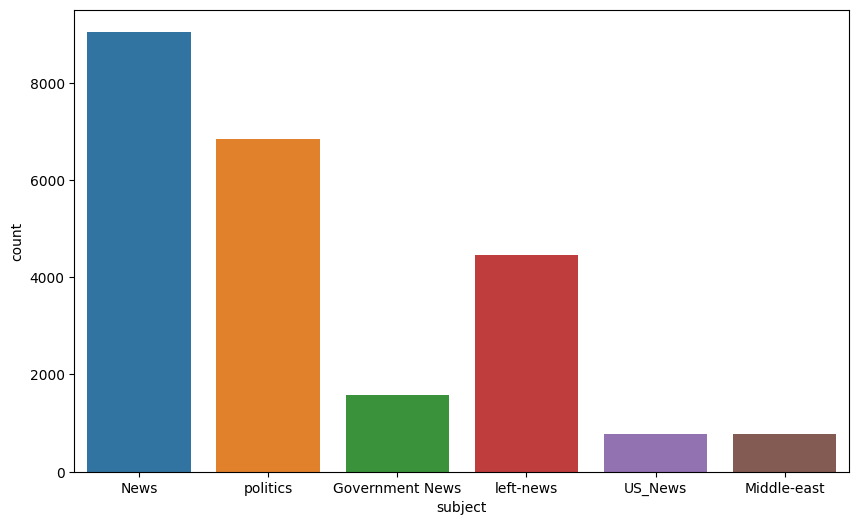

In [ ]:
plt.figure(figsize= (10, 6))
sns.countplot(x = 'subject', data = fake);

### Wordcloud

In [ ]:
text = ' '.join(fake['text'].tolist())

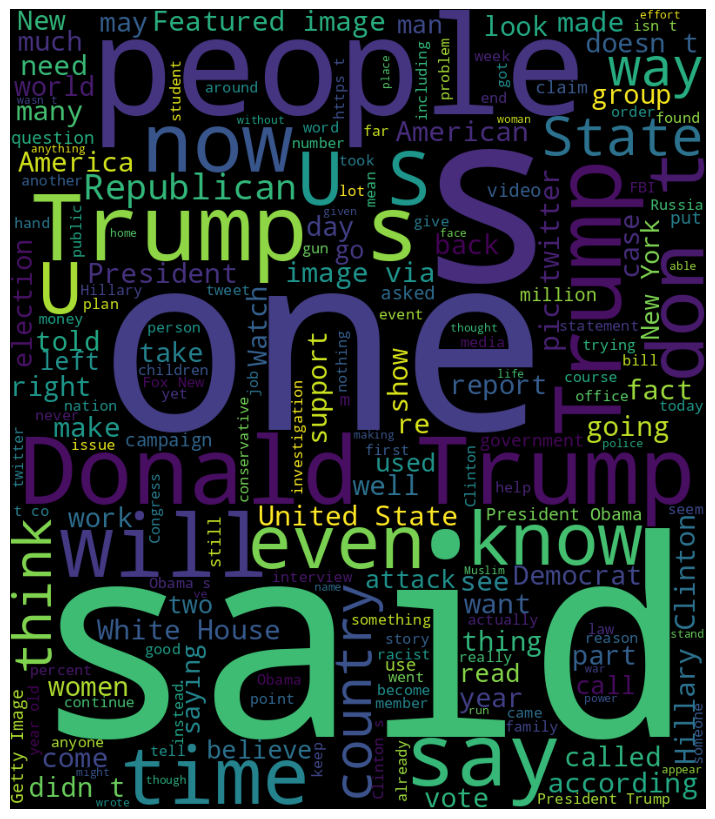

In [ ]:
wordcloud = WordCloud(width = 800, height = 920).generate(text)
fig = plt.figure(figsize= (10, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show();

## Exploring real news


In [ ]:
real = pd.read_csv('True.csv')
real

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [ ]:
text = ' '.join(real['text'].tolist())

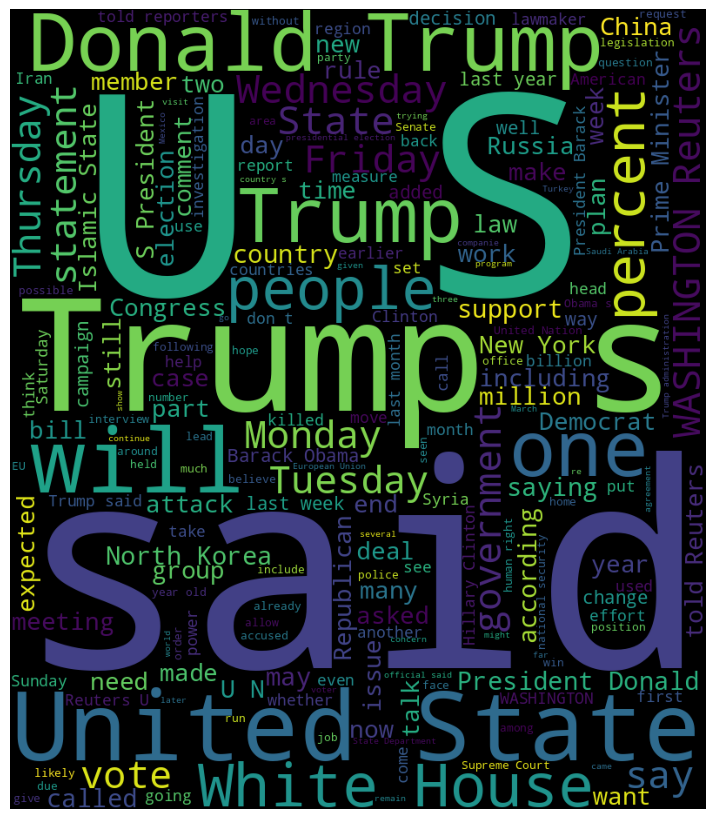

In [ ]:
wordcloud = WordCloud(width = 800, height = 920).generate(text)
fig = plt.figure(figsize= (10, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show();

### Difference in text
Real news seems to have source of publication which is not present in fake news set

Looking at the data:

* most of the text contains reuters information such as **WASHINGTON (Reuters)**
* Some text are tweets from tweeter
* Few text do not contain any publication info

### Cleaning data
Remove Reuters or Twitter Tweet information from the text

* Text can be splitted only once at '-' which is always present after mentioning source of publication, this gives us publication part and text part
* If we do not get text part, this means publication details wasn't given for that record
* The Twitter tweets always have same source, a long text of max 259 characters

In [ ]:
real.sample(5)

,title,text,subject,date
8958,Court decision shifts abortion battle to state...,(Reuters) - The battle over abortion was expec...,politicsNews,"June 28, 2016"
17795,Hong Kong leader says Asian financial hub face...,HONG KONG (Reuters) - Hong Kong s Chief Execut...,worldnews,"October 11, 2017"
6889,Factbox: Contenders for key jobs in Trump's ad...,(Reuters) - Below are people mentioned as cont...,politicsNews,"December 6, 2016"
3556,Civil rights group sues in U.S. court over imm...,(Reuters) - The American Civil Liberties Union...,politicsNews,"May 25, 2017"
17573,Kremlin raps U.S.A for not issuing visas to U....,MOSCOW (Reuters) - The Kremlin on Friday accus...,worldnews,"October 13, 2017"


In [ ]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit = 1)
    record[1]
    assert(len(record[0])<120)

  except:
    unknown_publishers.append(index)

In [ ]:
len(unknown_publishers)

222

In [ ]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
real = real.drop(8970, axis = 0)

In [ ]:
publisher = []
tmp_text = []
for index, row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')

  else:
    record = row.split('-', maxsplit = 1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [ ]:
real['publisher'] = publisher
real['text'] = tmp_text

In [ ]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
real.shape

(21416, 5)

In [ ]:
empty_fake_index = [index for index, text in enumerate(fake.text.tolist()) if str(text).strip()==""]
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
real['text'] = real['title'] + ' ' + real['text']
fake['text'] = fake['title'] + ' ' + fake['text']

In [ ]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

## Processing Text

In [ ]:
real['class'] = 1
fake['class'] = 0

In [ ]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [ ]:
real = real[['text', 'class']]
fake = fake[['text', 'class']]

In [ ]:
data = real.append(fake, ignore_index= True)
data

<ipython-input-26-164fe70d4280>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = real.append(fake, ignore_index= True)


,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
...,...,...
44892,mcpain: john mccain furious that iran treated ...,0
44893,justice? yahoo settles e-mail privacy class-ac...,0
44894,sunnistan: us and allied ‘safe zone’ plan to t...,0
44895,how to blow $700 million: al jazeera america f...,0


In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Calling preprocessing_text function on the news

X = []
sentences = list(data['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
# Sample cleaned up the news

X[2]

'senior republican senator let mr mueller job special counsel investigation links russia president trump election campaign continue without interference despite calls trump administration allies republican lawmakers shut prominent republican senator said sunday lindsey graham serves senate armed forces judiciary committees said department justice special counsel robert mueller needs carry russia investigation without political interference investigation go forward investigation conducted without political influence graham said cbs face nation news program need let mr mueller job think right guy right time question russia may interfered election trump campaign may links co ordinated effort loomed white house since trump took office january shows sign receding trump prepares second year power despite intensified rhetoric trump allies recent weeks accusing mueller team bias republican president trump seemed undercut supporters interview last week new york times said expected mueller going

In [ ]:
stop_words=set(stopwords.words('english'))

revised_texts=[]
for text in X:
  revised_text=[]
  words=text.split()
  for word in words:
    if word not in stop_words and word !='?' and len(word)>1:
      revised_text.append(word.lower())
  revised_texts.append(revised_text)

In [ ]:
print('The number of texts:',len(revised_texts))

The number of texts: 44897


## Tokenization

In [ ]:
tokenizer=Tokenizer(num_words=len(words),oov_token='<oov>')
tokenizer.fit_on_texts(revised_texts)
print('The dictionary of tokens and their indices:\n',tokenizer.word_index)

# Converting into sequences
sequences=tokenizer.texts_to_sequences(revised_texts)

print('\n The sequence of numbers:\n',sequences)

# Padding sequences
padded_sequences=pad_sequences(sequences)

print('\n The padded sequences:\n',padded_sequences)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print('The no of padded sequences:',len(padded_sequences))

The no of padded sequences: 44897


In [ ]:
print('The length of each padded sequence:',len(padded_sequences[0]))

The length of each padded sequence: 4978


## Splitting the dataset into train and test

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(padded_sequences, data['class'], test_size=0.2, random_state=100)

# Converting labels to numpy array
y_train=np.array(y_train)

y_test=np.array(y_test)

## Accessing the GLOVE Model

In [ ]:
"""!wget http://nlp.stanford.edu/data/glove.6B.zip"""

'!wget http://nlp.stanford.edu/data/glove.6B.zip'

In [ ]:
"""!unzip glove.6B.zip"""

'!unzip glove.6B.zip'

## Loading Glove embeddings

In [ ]:
%%time
glove_embeddings={} # empty dictionary
with open('glove.6B.50d.txt') as f:
  for line in f:
    line=line.split()
    glove_embeddings[line[0]]=np.array(line[1:])

CPU times: user 6.88 s, sys: 1.03 s, total: 7.91 s
Wall time: 10.9 s


In [ ]:
print('The no of Glove Embeddings:',len(glove_embeddings))

The no of Glove Embeddings: 400000


In [ ]:
print(glove_embeddings['states'])

['-0.42093' '0.045655' '0.1135' '0.34526' '0.09715' '0.42206' '-0.34718'
 '0.010904' '0.61307' '-0.5734' '0.29023' '-0.21015' '0.14544' '-0.31479'
 '0.16471' '0.059054' '0.16791' '-0.58768' '-0.063237' '0.084685'
 '0.21251' '-0.5246' '0.46017' '-0.044725' '-0.20827' '-2.3662' '0.37637'
 '-0.68911' '0.020944' '-0.17156' '3.3658' '-0.10865' '-0.49856'
 '-0.84937' '-0.15947' '-0.92705' '-0.3499' '0.29612' '-0.96039'
 '-0.13339' '-0.47849' '-0.057402' '1.3791' '-0.68087' '-0.29211'
 '0.79177' '-0.7364' '0.13431' '-0.79519' '0.19546']


In [ ]:
print(glove_embeddings['people'])

['0.95281' '-0.20608' '0.55618' '-0.46323' '0.73354' '0.029137' '-0.19367'
 '-0.090066' '-0.22958' '-0.19058' '-0.34857' '-1.0231' '0.743' '-0.5489'
 '0.88484' '-0.14051' '0.0040139' '0.58448' '0.10767' '-0.44657'
 '-0.43205' '0.9868' '0.78288' '0.51513' '0.85788' '-1.7713' '-0.88259'
 '-0.59728' '0.084934' '-0.48112' '3.9678' '0.8893' '-0.27064' '-0.44094'
 '-0.26213' '0.085597' '0.022099' '-0.58376' '0.10908' '0.77973'
 '-0.95447' '0.40482' '0.8941' '0.65251' '0.39858' '0.20884' '-1.3281'
 '-0.10882' '-0.22822' '-0.46303']


In [ ]:
print(glove_embeddings['population'])

['0.36062' '-0.26441' '0.27259' '-0.96272' '1.0993' '0.82948' '-0.3688'
 '-1.1358' '0.30867' '-0.5805' '0.54634' '-1.6902' '1.6623' '-1.1231'
 '0.39183' '-0.084451' '0.52992' '0.051941' '-0.67467' '0.92963'
 '-0.96431' '-0.55312' '0.32131' '0.76165' '0.24344' '-0.57555' '-0.37746'
 '-0.69368' '0.11516' '0.71955' '3.3259' '0.18065' '0.46575' '-0.6896'
 '0.022578' '-0.51935' '-0.45908' '-0.49501' '0.2609' '0.78993' '-1.3758'
 '-0.09019' '1.2402' '0.044465' '-0.80741' '0.38581' '-0.565' '-0.12063'
 '0.21548' '-0.29169']


## Creating a matrix of Glove embeddings for tokens

In [ ]:
embeddings_length =50

# Creating a zero matrix
word_embeddings=np.zeros((len(tokenizer.index_word)+1, embeddings_length)) # +1 as the index of embeddings start with 1

for index,word in tokenizer.index_word.items():
  word_embeddings[index]=glove_embeddings.get(word,np.zeros(embeddings_length))

In [ ]:
print(word_embeddings)

[[ 0.       0.       0.      ...  0.       0.       0.     ]
 [ 0.       0.       0.      ...  0.       0.       0.     ]
 [ 0.45769  0.85191  0.31098 ... -0.74226  0.77053  0.26394]
 ...
 [ 0.       0.       0.      ...  0.       0.       0.     ]
 [-0.11366 -0.86029  0.62369 ... -0.5042   1.126    0.26226]
 [ 0.       0.       0.      ...  0.       0.       0.     ]]


In [ ]:
print('The length of word embeddings:',len(word_embeddings))

The length of word embeddings: 115332


In [ ]:
print('The length of word embeddings[0]:',len(word_embeddings[0]))

The length of word embeddings[0]: 50


In [ ]:
print('The length of word embeddings[10]:',len(word_embeddings[10]))

The length of word embeddings[10]: 50


Many tokens are not there in the GLOVE

## Creating RNN Models

### 1. LSTM

In [ ]:
from keras.layers import LSTM

# Neural Network architecture
lstm_model=tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                    output_dim=embeddings_length,
                                    trainable=False,
                                    weights=[word_embeddings]))
lstm_model.add(LSTM(50))

lstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          5766600   
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 5,786,851
Trainable params: 20,251
Non-trainable params: 5,766,600
_________________________________________________________________
None


In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size= 50, epochs= 3, verbose=1, validation_split=0.2)

Epoch 1/3
575/575 [==============================] - 1856s 3s/step - loss: 0.2444 - accuracy: 0.9061 - val_loss: 0.1801 - val_accuracy: 0.9315
Epoch 2/3
575/575 [==============================] - 1792s 3s/step - loss: 0.1793 - accuracy: 0.9358 - val_loss: 0.1447 - val_accuracy: 0.9486
Epoch 3/3
575/575 [==============================] - 1774s 3s/step - loss: 0.1809 - accuracy: 0.9322 - val_loss: 0.1935 - val_accuracy: 0.9209


In [ ]:
# Predictions on the Test Set

score_lstm = lstm_model.evaluate(X_test, y_test, verbose=1)

281/281 [==============================] - 200s 712ms/step - loss: 0.1909 - accuracy: 0.9200


In [ ]:
# Model Performance

print("Test Score:", score_lstm[0])
print("Test Accuracy:", score_lstm[1])

Test Score: 0.19085699319839478
Test Accuracy: 0.9200445413589478


In [ ]:
lstm_train_accuracy= 93.22
lstm_train_loss= 18.09
lstm_test_accuracy= 92
lstm_test_loss= 19.08

In [ ]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./lstm_model_acc_{round(score_lstm[1], 3)}.h5", save_format='h5')

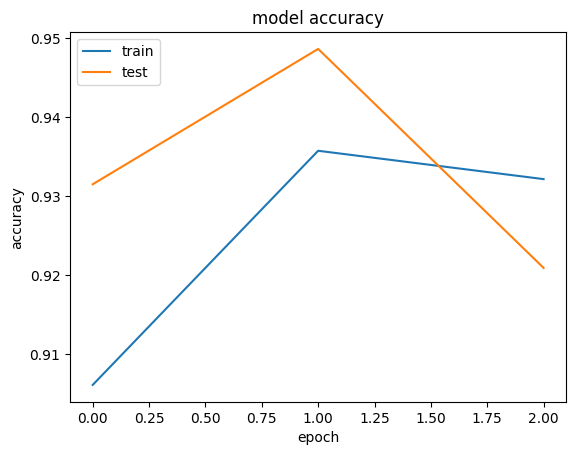

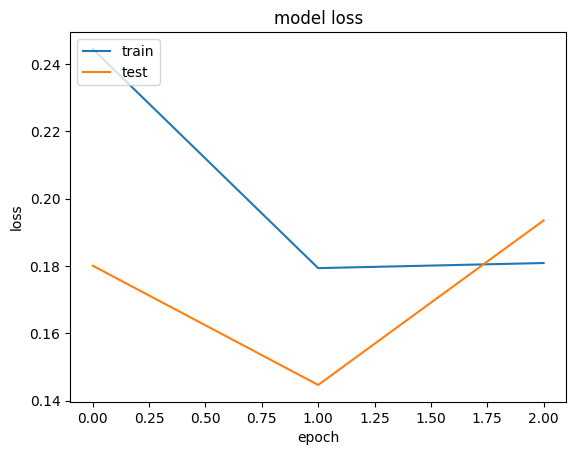

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['accuracy'])
plt.plot(lstm_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### 2. GRU

In [ ]:
from keras.layers import GRU

# Neural Network architecture

gru_model = Sequential()

gru_model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                    output_dim=embeddings_length,
                                    trainable=False,
                                    weights=[word_embeddings]))
gru_model.add(GRU(50))

gru_model.add(Dense(1, activation='sigmoid'))

# Model compiling

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          5766600   
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,781,951
Trainable params: 15,351
Non-trainable params: 5,766,600
_________________________________________________________________
None


In [ ]:
# Model Training

gru_model_history = gru_model.fit(X_train, y_train, batch_size= 50, epochs= 3, verbose=1, validation_split=0.2)

Epoch 1/3
575/575 [==============================] - 1914s 3s/step - loss: 0.2149 - accuracy: 0.9239 - val_loss: 0.1774 - val_accuracy: 0.9424
Epoch 2/3
575/575 [==============================] - 1889s 3s/step - loss: 0.1658 - accuracy: 0.9408 - val_loss: 0.1366 - val_accuracy: 0.9555
Epoch 3/3
575/575 [==============================] - 1895s 3s/step - loss: 0.1159 - accuracy: 0.9625 - val_loss: 0.1014 - val_accuracy: 0.9694


In [ ]:
# Predictions on the Test Set

score_gru = gru_model.evaluate(X_test, y_test, verbose=1)

281/281 [==============================] - 182s 649ms/step - loss: 0.1012 - accuracy: 0.9692


In [ ]:
# Saving the model as a h5 file for possible use later

gru_model.save(f"./gru_model_acc_{round(score_gru[1], 3)}.h5", save_format='h5')

In [ ]:
gru_train_accuracy= 96.25
gru_train_loss= 11.59
gru_test_accuracy= 96.92
gru_test_loss= 10.12

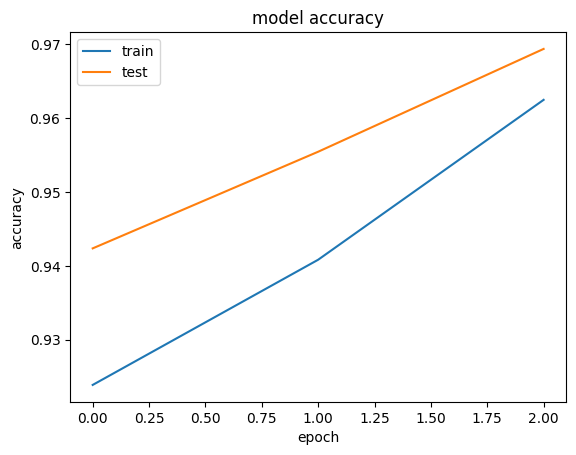

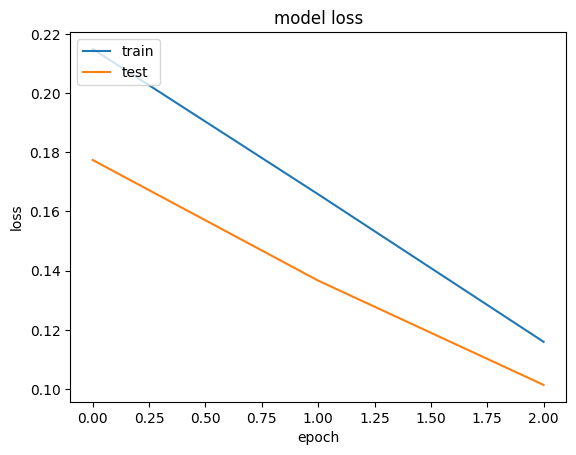

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(gru_model_history.history['accuracy'])
plt.plot(gru_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(gru_model_history.history['loss'])
plt.plot(gru_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### 3. Deep LSTM

In [ ]:
from keras.layers import LSTM

# Neural Network architecture
deep_lstm=Sequential()

deep_lstm.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                    output_dim=embeddings_length,
                                    trainable=False,
                                    weights=[word_embeddings]))
deep_lstm.add(LSTM(10,return_sequences=True, dropout= 0.2))
deep_lstm.add(LSTM(5,return_sequences=True, dropout= 0.2))
deep_lstm.add(LSTM(5,return_sequences=False, dropout= 0.2))

deep_lstm.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

deep_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(deep_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          5766600   
                                                                 
 lstm (LSTM)                 (None, None, 10)          2440      
                                                                 
 lstm_1 (LSTM)               (None, None, 5)           320       
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 5,769,586
Trainable params: 2,986
Non-trainable params: 5,766,600
_________________________________________________________________
None


In [ ]:
# Model Training

deep_lstm_history = deep_lstm.fit(X_train, y_train, batch_size= 50, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
575/575 [==============================] - 7002s 12s/step - loss: 0.3977 - accuracy: 0.8482 - val_loss: 0.2945 - val_accuracy: 0.8937
Epoch 2/3
575/575 [==============================] - 6989s 12s/step - loss: 0.2630 - accuracy: 0.9029 - val_loss: 0.2202 - val_accuracy: 0.9098
Epoch 3/3
575/575 [==============================] - 6930s 12s/step - loss: 0.2282 - accuracy: 0.9136 - val_loss: 0.1827 - val_accuracy: 0.9368


In [ ]:
# Predictions on the Test Set

score_deep_lstm = deep_lstm.evaluate(X_test, y_test, verbose=1)

281/281 [==============================] - 316s 1s/step - loss: 0.1693 - accuracy: 0.9422


In [ ]:
deep_lstm_train_accuracy= 91.36
deep_lstm_train_loss= 22.82
deep_lstm_test_accuracy= 94.22
deep_lstm_test_loss= 16.93

In [ ]:
# Model Performance

print("Test Score:", score_deep_lstm[0])
print("Test Accuracy:", score_deep_lstm[1])

Test Score: 0.1692768782377243
Test Accuracy: 0.9422048926353455


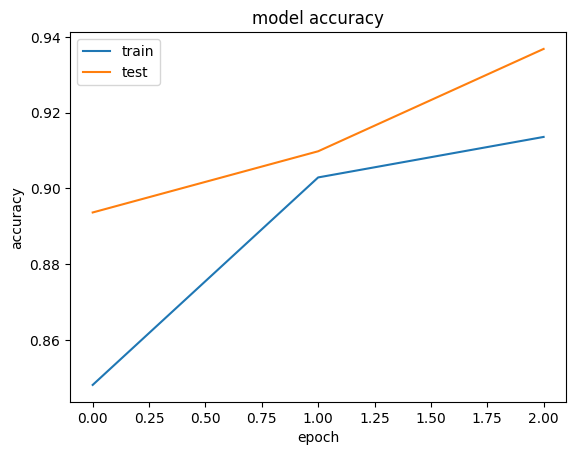

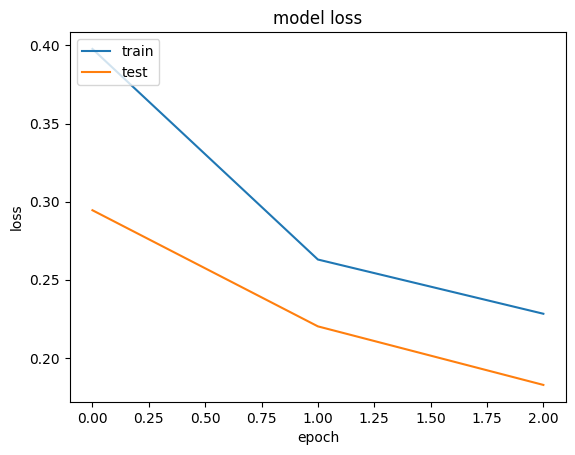

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(deep_lstm_history.history['accuracy'])
plt.plot(deep_lstm_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(deep_lstm_history.history['loss'])
plt.plot(deep_lstm_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### 4. Deep GRU

In [ ]:
from keras.layers import GRU

# Neural Network architecture
deep_gru= Sequential()

deep_gru.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                    output_dim=embeddings_length,
                                    trainable=False,
                                    weights=[word_embeddings]))
deep_gru.add(GRU(10,return_sequences=True, dropout= 0.2))
deep_gru.add(GRU(5,return_sequences=True, dropout= 0.2))
deep_gru.add(GRU(5,return_sequences=False, dropout= 0.2))

deep_gru.add(Dense(1, activation='sigmoid'))

In [ ]:
# Model compiling

deep_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(deep_gru.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          5766600   
                                                                 
 gru (GRU)                   (None, None, 10)          1860      
                                                                 
 gru_1 (GRU)                 (None, None, 5)           255       
                                                                 
 gru_2 (GRU)                 (None, 5)                 180       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 5,768,901
Trainable params: 2,301
Non-trainable params: 5,766,600
_________________________________________________________________
None


In [ ]:
# Model Training

deep_gru_history = deep_gru.fit(X_train, y_train, batch_size= 50, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
575/575 [==============================] - 7419s 13s/step - loss: 0.3254 - accuracy: 0.8775 - val_loss: 0.1948 - val_accuracy: 0.9360
Epoch 2/3
575/575 [==============================] - 7435s 13s/step - loss: 0.1820 - accuracy: 0.9397 - val_loss: 0.1538 - val_accuracy: 0.9506
Epoch 3/3
575/575 [==============================] - 7467s 13s/step - loss: 0.1463 - accuracy: 0.9517 - val_loss: 0.1168 - val_accuracy: 0.9639


In [ ]:
# Predictions on the Test Set

score_deep_gru = deep_gru.evaluate(X_test, y_test, verbose=1)

281/281 [==============================] - 281s 999ms/step - loss: 0.1111 - accuracy: 0.9660


In [ ]:
deep_gru_train_accuracy= 95.17
deep_gru_train_loss= 14.63
deep_gru_test_accuracy= 96.6
deep_gru_test_loss= 11.11

In [ ]:
# Model Performance

print("Test Score:", score_deep_gru[0])
print("Test Accuracy:", score_deep_gru[1])

Test Score: 0.11107486486434937
Test Accuracy: 0.9660356640815735


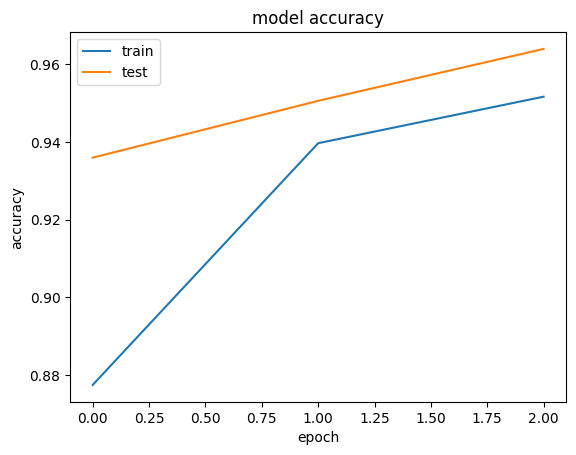

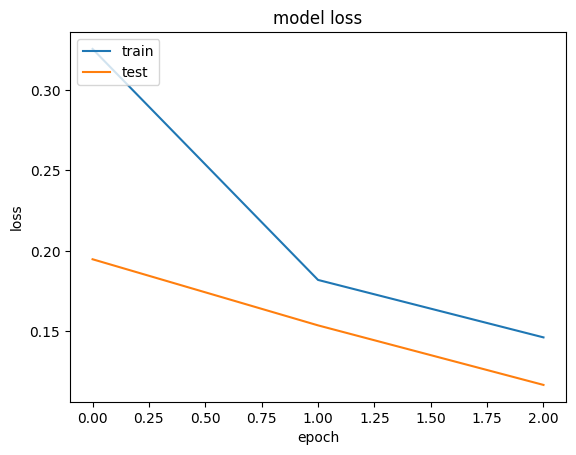

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(deep_gru_history.history['accuracy'])
plt.plot(deep_gru_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(deep_gru_history.history['loss'])
plt.plot(deep_gru_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### 5. Bidirectional LSTM

In [ ]:
# Neural Network architecture
import tensorflow as tf

bidirectional_lstm= Sequential()

bidirectional_lstm.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                    output_dim=embeddings_length,
                                    trainable=False,
                                    weights=[word_embeddings]))

bidirectional_lstm.add(tf.keras.layers.Bidirectional(LSTM(50,return_sequences=False,dropout=0.2)))

bidirectional_lstm.add(tf.keras.layers.Dense(1))

In [ ]:
# Model compiling

bidirectional_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(bidirectional_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          5766600   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              40400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,807,101
Trainable params: 40,501
Non-trainable params: 5,766,600
_________________________________________________________________
None


In [ ]:
# Model Training
bidirectional_model_history = bidirectional_lstm.fit(X_train, y_train, batch_size= 50, epochs= 3, verbose=1, validation_split=0.2)

Epoch 1/3
575/575 [==============================] - 1873s 3s/step - loss: 0.3246 - accuracy: 0.8864 - val_loss: 0.6490 - val_accuracy: 0.6559
Epoch 2/3
575/575 [==============================] - 1870s 3s/step - loss: 0.2726 - accuracy: 0.9057 - val_loss: 0.1974 - val_accuracy: 0.9368
Epoch 3/3
575/575 [==============================] - 1878s 3s/step - loss: 0.2303 - accuracy: 0.9292 - val_loss: 0.2891 - val_accuracy: 0.8909


In [ ]:
# Predictions on the Test Set

score_bidirectional = bidirectional_lstm.evaluate(X_test, y_test, verbose=1)

281/281 [==============================] - 213s 759ms/step - loss: 0.2816 - accuracy: 0.8883


In [ ]:
bidirectional_lstm_train_accuracy= 92.92
bidirectional_lstm_train_loss= 23.03
bidirectional_lstm_test_accuracy= 88.83
bidirectional_lstm_test_loss= 28.16

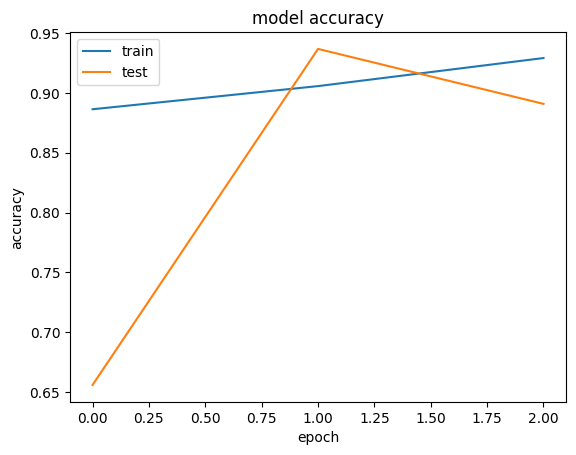

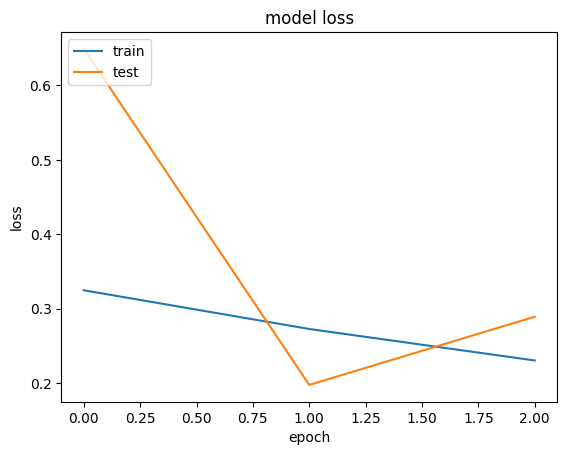

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(bidirectional_model_history.history['accuracy'])
plt.plot(bidirectional_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(bidirectional_model_history.history['loss'])
plt.plot(bidirectional_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### 6. Bidirectional GRU

In [ ]:
from keras.layers import GRU
import tensorflow as tf

# Neural Network architecture

bidirectional_gru= Sequential()

bidirectional_gru.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                    output_dim=embeddings_length,
                                    trainable=False,
                                    weights=[word_embeddings]))

bidirectional_gru.add(tf.keras.layers.Bidirectional(GRU(50,return_sequences=False,dropout=0.2)))

bidirectional_gru.add(tf.keras.layers.Dense(1))

In [ ]:
# Model compiling

bidirectional_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(bidirectional_gru.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          5766600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              30600     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,797,301
Trainable params: 30,701
Non-trainable params: 5,766,600
_________________________________________________________________
None


In [ ]:
# Model Training

bidirectional_gru_model_history = bidirectional_gru.fit(X_train, y_train, batch_size= 50, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
575/575 [==============================] - 1976s 3s/step - loss: 0.3859 - accuracy: 0.8738 - val_loss: 0.4238 - val_accuracy: 0.7616
Epoch 2/3
575/575 [==============================] - 1951s 3s/step - loss: 0.3674 - accuracy: 0.8830 - val_loss: 0.2547 - val_accuracy: 0.9223
Epoch 3/3
575/575 [==============================] - 1950s 3s/step - loss: 0.2508 - accuracy: 0.9362 - val_loss: 0.2932 - val_accuracy: 0.8806


In [ ]:
# Predictions on the Test Set

score_bidirectional_gru = bidirectional_gru.evaluate(X_test, y_test, verbose=1)

281/281 [==============================] - 185s 658ms/step - loss: 0.2952 - accuracy: 0.8791


In [ ]:
bidirectional_gru_train_accuracy= 93.62
bidirectional_gru_train_loss= 25.08
bidirectional_gru_test_accuracy= 87.91
bidirectional_gru_test_loss= 29.52

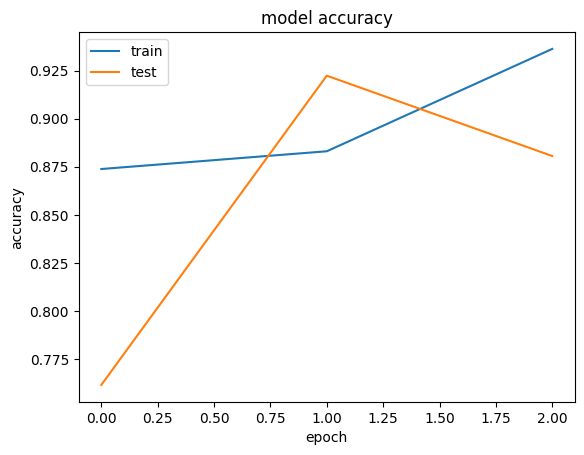

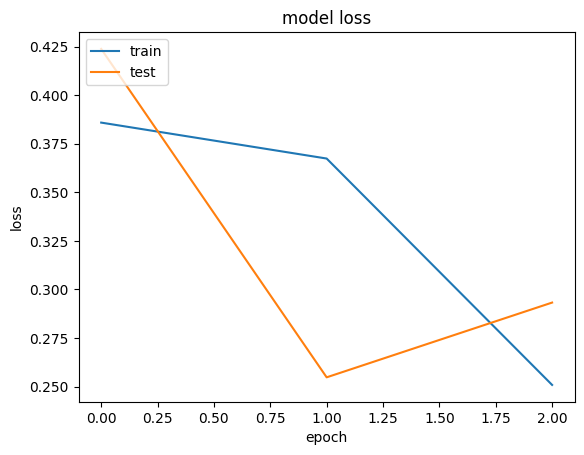

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(bidirectional_gru_model_history.history['accuracy'])
plt.plot(bidirectional_gru_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(bidirectional_gru_model_history.history['loss'])
plt.plot(bidirectional_gru_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Best Model

In [ ]:
accuracy= {"Name":['LSTM','GRU','Deep LSTM','Deep GRU', 'Bidirectional LSTM', 'Bidirectional GRU'],
              "Train Accuracy":[lstm_train_accuracy, gru_train_accuracy, deep_lstm_train_accuracy,
                                deep_gru_train_accuracy, bidirectional_lstm_train_accuracy, bidirectional_gru_train_accuracy],
              "Test Accuracy":[lstm_test_accuracy, gru_test_accuracy, deep_lstm_test_accuracy,
                                deep_gru_test_accuracy, bidirectional_lstm_test_accuracy, bidirectional_gru_test_accuracy]}

# Printing the dataframe
accuracy_df = pd.DataFrame(accuracy)

accuracy_df

,Name,Train Accuracy,Test Accuracy
0,LSTM,93.22,92.00
1,GRU,96.25,96.92
2,Deep LSTM,91.36,94.22
3,Deep GRU,95.17,96.60
4,Bidirectional LSTM,92.92,88.83
5,Bidirectional GRU,93.62,87.91


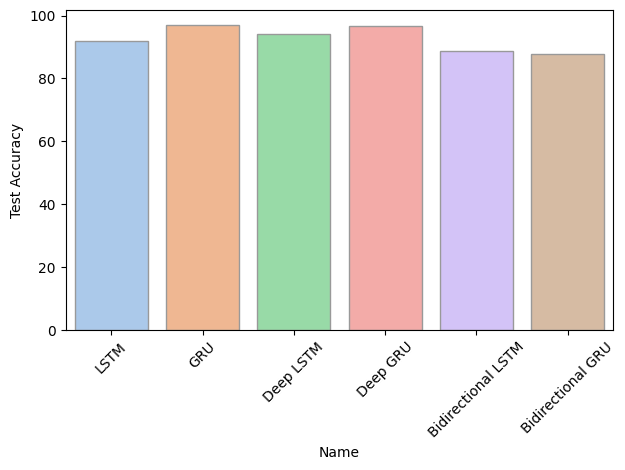

In [ ]:
# Create unstacked multiple columns bar
import seaborn as sns

sns.barplot(data=accuracy_df, x="Name", y="Test Accuracy", palette="pastel", edgecolor=".6");
plt.xticks(rotation=45)
plt.tight_layout();

## Best Model GRU

# Hyper Parameter Tuning of the GRU Model


## GRU Model 1 with more units

In [ ]:
from keras.layers import GRU

# Neural Network architecture
gru_model2 = Sequential()

gru_model2.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                    output_dim=embeddings_length,
                                    trainable=False,
                                    weights=[word_embeddings]))
gru_model2.add(GRU(70))

gru_model2.add(Dense(1, activation='sigmoid'))

# Model compiling
gru_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(gru_model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          5766600   
                                                                 
 gru (GRU)                   (None, 70)                25620     
                                                                 
 dense (Dense)               (None, 1)                 71        
                                                                 
Total params: 5,792,291
Trainable params: 25,691
Non-trainable params: 5,766,600
_________________________________________________________________
None


In [ ]:
# Model Training

gru_model_history2 = gru_model2.fit(X_train, y_train, batch_size= 50, epochs= 3, verbose=1, validation_split=0.2)

Epoch 1/3
575/575 [==============================] - 2109s 4s/step - loss: 0.1909 - accuracy: 0.9332 - val_loss: 0.1330 - val_accuracy: 0.9550
Epoch 2/3
575/575 [==============================] - 1933s 3s/step - loss: 0.1255 - accuracy: 0.9580 - val_loss: 0.1058 - val_accuracy: 0.9651
Epoch 3/3
575/575 [==============================] - 1882s 3s/step - loss: 0.1143 - accuracy: 0.9607 - val_loss: 0.1493 - val_accuracy: 0.9471


In [ ]:
# Predictions on the Test Set

score_gru2 = gru_model2.evaluate(X_test, y_test, verbose=1)

281/281 [==============================] - 173s 614ms/step - loss: 0.1534 - accuracy: 0.9465


In [ ]:
gru_train_accuracy2= 96.07
gru_train_loss2= 11.43
gru_test_accuracy2= 94.65
gru_test_loss2= 15.34

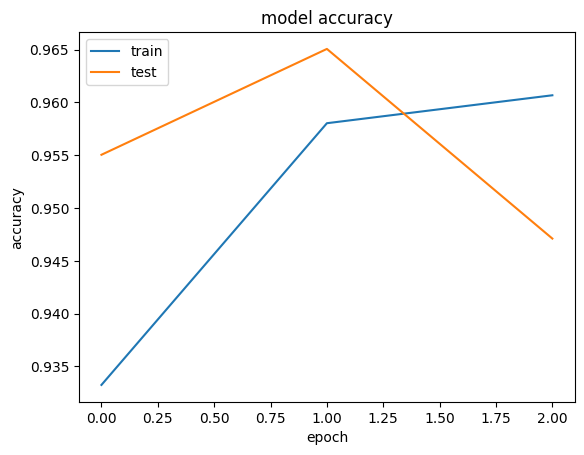

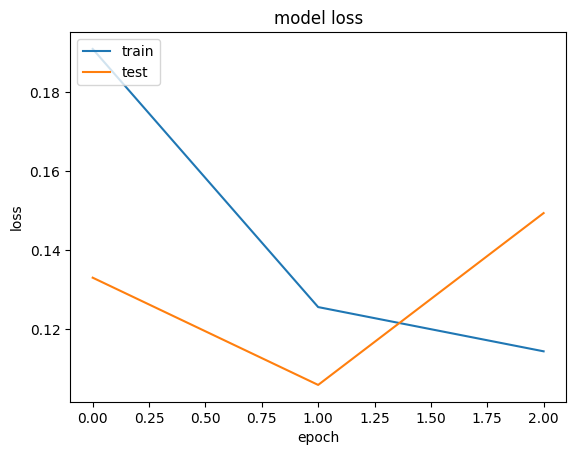

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(gru_model_history2.history['accuracy'])
plt.plot(gru_model_history2.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(gru_model_history2.history['loss'])
plt.plot(gru_model_history2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## GRU Model 2 with more units and 10% dropout

In [ ]:
from keras.layers import GRU
from keras.layers.core import Dropout
# Neural Network architecture

gru_model3 = Sequential()

gru_model3.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                                    output_dim=embeddings_length,
                                    trainable=False,
                                    weights=[word_embeddings]))
gru_model3.add(GRU(70))

gru_model3.add(Dropout(0.1))

gru_model3.add(Dense(1, activation='sigmoid'))

# Model compiling

gru_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(gru_model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          5766600   
                                                                 
 gru_2 (GRU)                 (None, 70)                25620     
                                                                 
 dropout_1 (Dropout)         (None, 70)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 71        
                                                                 
Total params: 5,792,291
Trainable params: 25,691
Non-trainable params: 5,766,600
_________________________________________________________________
None


In [ ]:
# Model Training

gru_model_history3 = gru_model3.fit(X_train, y_train, batch_size= 50, epochs= 3, verbose=1, validation_split=0.2)

Epoch 1/3
575/575 [==============================] - 2037s 4s/step - loss: 0.2094 - accuracy: 0.9210 - val_loss: 0.1507 - val_accuracy: 0.9468
Epoch 2/3
575/575 [==============================] - 1906s 3s/step - loss: 0.1326 - accuracy: 0.9573 - val_loss: 0.1102 - val_accuracy: 0.9660
Epoch 3/3
575/575 [==============================] - 1922s 3s/step - loss: 0.1141 - accuracy: 0.9627 - val_loss: 0.0894 - val_accuracy: 0.9717


In [ ]:
# Predictions on the Test Set

score_gru3 = gru_model3.evaluate(X_test, y_test, verbose=1)

281/281 [==============================] - 218s 774ms/step - loss: 0.0871 - accuracy: 0.9724


In [ ]:
gru_train_accuracy3= 96.27
gru_train_loss3= 11.41
gru_test_accuracy3= 97.24
gru_test_loss3= 8.71

In [ ]:
# Saving the model as a h5 file for possible use later

gru_model3.save(f"./gru_model3_acc_{round(score_gru3[1], 3)}.h5", save_format='h5')

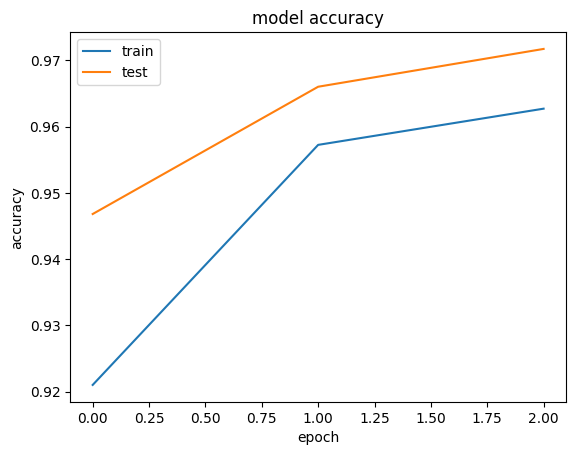

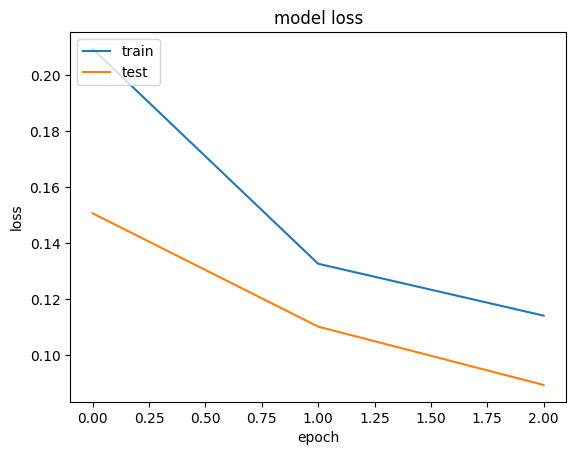

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(gru_model_history3.history['accuracy'])
plt.plot(gru_model_history3.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(gru_model_history3.history['loss'])
plt.plot(gru_model_history3.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## GRU Accuracy Dataframe

In [ ]:
import pandas as pd

gru_accuracy= {"GRU Model Number":['Model 1','Model 2','Model 3'],
              "Train Accuracy":[gru_train_accuracy, gru_train_accuracy2, gru_train_accuracy3],
              "Test Accuracy":[gru_test_accuracy, gru_test_accuracy2, gru_test_accuracy3]}

# Printing the dataframe
gru_accuracy_df = pd.DataFrame(gru_accuracy)

gru_accuracy_df

,GRU Model Number,Train Accuracy,Test Accuracy
0,Model 1,96.25,96.92
1,Model 2,96.07,94.65
2,Model 3,96.27,97.24


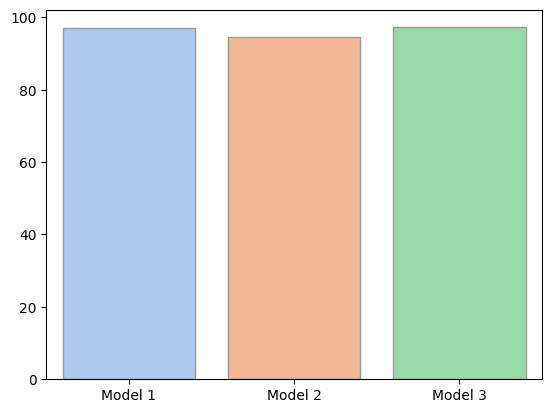

In [ ]:
# Create unstacked multiple columns bar

import seaborn as sns
sns.barplot(data = gru_accuracy, x="GRU Model Number", y="Test Accuracy", palette="pastel", edgecolor=".6");

### Model 3 has the best performance

# Performance of the model

In [ ]:
from keras.models import load_model

model_path ='./gru_model3_acc_0.972.h5'
pretrained_gru_model = load_model(model_path)

# summarize model.
pretrained_gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          5766600   
                                                                 
 gru_1 (GRU)                 (None, 70)                25620     
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 71        
                                                                 
Total params: 5,792,291
Trainable params: 25,691
Non-trainable params: 5,766,600
_________________________________________________________________


In [ ]:
print("Accuracy of the model on Training Data is - " , pretrained_gru_model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , pretrained_gru_model.evaluate(X_test,y_test)[1]*100 , "%")

1123/1123 [==============================] - 774s 689ms/step - loss: 0.0842 - accuracy: 0.9737
Accuracy of the model on Training Data is -  97.37171530723572 %
281/281 [==============================] - 190s 676ms/step - loss: 0.0871 - accuracy: 0.9724
Accuracy of the model on Testing Data is -  97.23830819129944 %


In [ ]:
predict_x = pretrained_gru_model.predict(X_test)
pred = np.argmax(predict_x,axis=1)
pred[:5]

281/281 [==============================] - 199s 703ms/step


array([0, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

              precision    recall  f1-score   support

        Fake       0.53      1.00      0.69      4726
    Not Fake       0.00      0.00      0.00      4254

    accuracy                           0.53      8980
   macro avg       0.26      0.50      0.34      8980
weighted avg       0.28      0.53      0.36      8980



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[4726,    0],
       [4254,    0]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(95.72222222222221, 0.5, 'Actual')

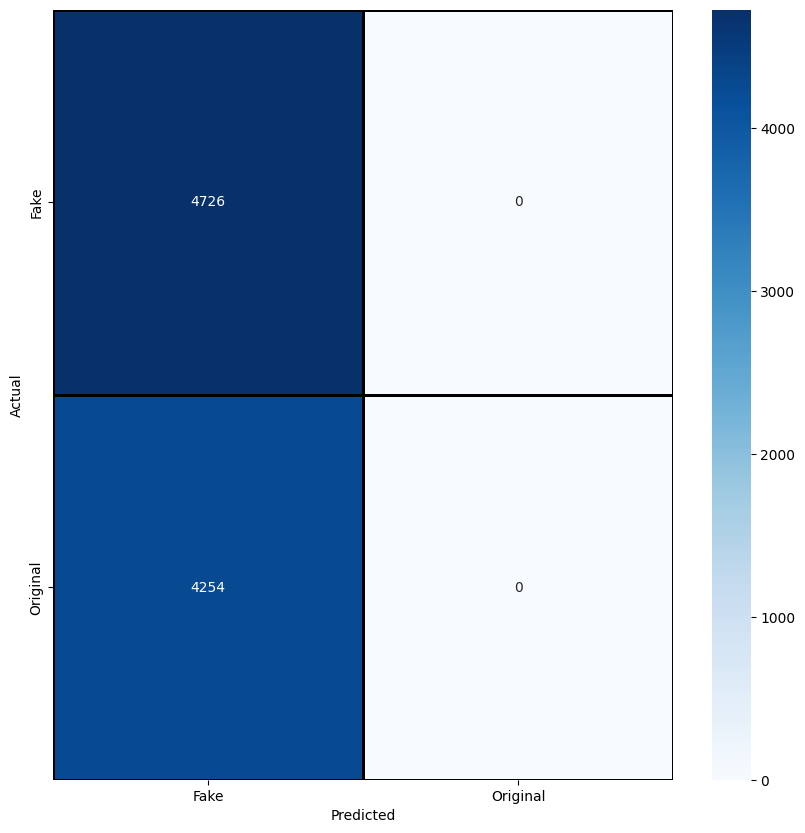

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, pred, average='micro')

0.5262806236080179

In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, pred, average='micro')

0.5262806236080179